In [43]:
import pandas as pd # IMPORTS
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [44]:
bankDF = pd.read_csv("../Base.csv") # Utilize the dataset that best represents the original dataset
y_true = bankDF['fraud_bool']

<AxesSubplot: >

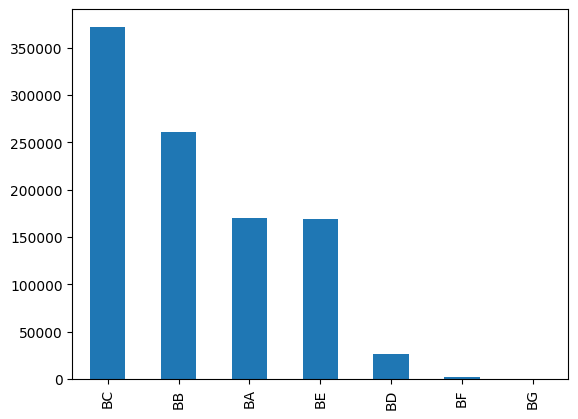

In [45]:
bankDF['housing_status'].value_counts().plot(kind='bar')

<AxesSubplot: ylabel='Frequency'>

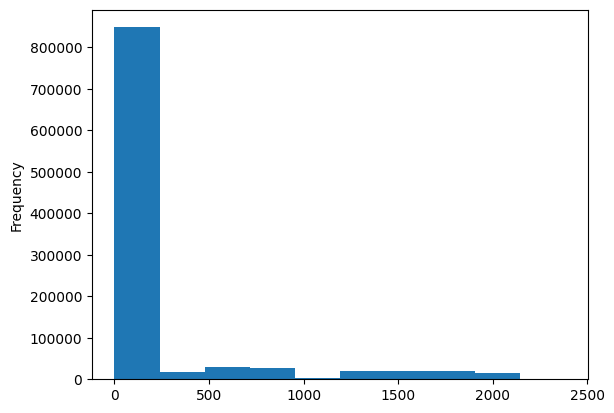

In [46]:
bankDF.bank_branch_count_8w.plot.hist() # Experiment with the data

Text(0, 0.5, 'fraud_bool')

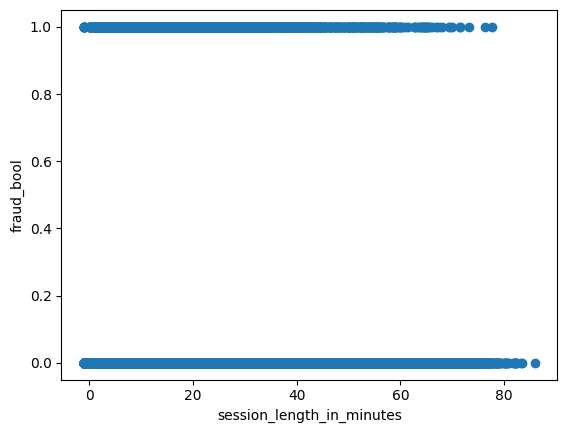

In [47]:
plt.scatter(bankDF['session_length_in_minutes'], bankDF['fraud_bool'])
plt.xlabel('session_length_in_minutes')
plt.ylabel('fraud_bool')

In [48]:
def train(isf, ensemble, sample_size, filtered_data):
    model_list = list()
    for i in range(ensemble):
        to_train = filtered_data.sample(sample_size)
        temp = isf.fit(to_train)
        model_list.append(temp)
    return model_list

def predict(model_list, X_test):
    pass1 = list()
    for model in model_list:
        y_pred = model.predict(X_test)
        y_pred_binary = [1 if x == -1 else 0 for x in y_pred]
        pass1.append(y_pred_binary)
    res = list() # Get a "vote" for which classification each model thinks would work best
    for j in range(len(pass1[0])): # Iterates through each prediction
        count_zero = 0
        count_one = 0
        for i in range(len(pass1)): # Iterates through each model's prediction set
            if pass1[i][j] == 0:
                count_zero += 1
            else:
                count_one += 1
        if (count_zero > count_one):
            res.append(0)
        else:
            res.append(1)
    return res

In [50]:
used_cols = ["income","name_email_similarity", "prev_address_months_count", "current_address_months_count", "customer_age", "days_since_request", "intended_balcon_amount", "zip_count_4w", "velocity_6h", "velocity_24h", "velocity_4w", "bank_branch_count_8w", "date_of_birth_distinct_emails_4w", "credit_risk_score", "email_is_free", "phone_home_valid", "phone_mobile_valid", "bank_months_count", "has_other_cards", "proposed_credit_limit", "foreign_request", "session_length_in_minutes", "keep_alive_session"] #, "foreign_request", "device_distinct_emails_8w"]
# filtered_data = bankDF[used_cols]
# X_train, X_test, y_train, y_test = train_test_split(filtered_data, y_true, test_size=0.3, random_state=42) # Random state same as the other one, use 30% for testing
# X_train.head()

In [57]:
# Cell for feature engineering one model
isf = IsolationForest(n_estimators=100, max_samples='auto',
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)
good_cols = bankDF[used_cols]
random_cols = ['income', 'customer_age', 'zip_count_4w', 'foreign_request', 'proposed_credit_limit']
filtered_data = good_cols[random_cols]
X_train, X_test, y_train, y_test = train_test_split(filtered_data, y_true, test_size=0.3, random_state=42)
model_list = train(isf, 7, 30000, filtered_data)
y_processed = y_test.values
y_pred_binary = predict(model_list, X_test)
roc = roc_auc_score(y_processed, y_pred_binary)
roc

0.6099634673146788

In [68]:
good_cols = bankDF[used_cols]
isf = IsolationForest(n_estimators=100, max_samples='auto',
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)

# isf.fit(X_train, isf)
best_roc = 0
best_cols = list()
for n in range(1, 23):
    for x in range(70):
        random_cols = np.random.choice(good_cols.columns, size=n, replace=False) # How many random features to take

        filtered_data = good_cols[random_cols]
        X_train, X_test, y_train, y_test = train_test_split(filtered_data, y_true, test_size=0.3, random_state=42)
        model_list = train(isf, 5, 30000, filtered_data)
        y_processed = y_test.values
        y_pred_binary = predict(model_list, X_test)
        roc = roc_auc_score(y_processed, y_pred_binary)
        if roc > best_roc:
            best_roc = roc
            best_cols = random_cols
            print("Best Columns: ")
            print(random_cols)
            print("Best ROC AUC: " + str(roc))

Best Columns: 
['email_is_free']
Best ROC AUC: 0.5
Best Columns: 
['days_since_request']
Best ROC AUC: 0.5052505351136851
Best Columns: 
['velocity_4w']
Best ROC AUC: 0.5314821459712982
Best Columns: 
['proposed_credit_limit']
Best ROC AUC: 0.6052023132488998
Best Columns: 
['proposed_credit_limit']
Best ROC AUC: 0.6062964359037679
Best Columns: 
['current_address_months_count' 'proposed_credit_limit']
Best ROC AUC: 0.614557958243971
Best Columns: 
['customer_age' 'proposed_credit_limit']
Best ROC AUC: 0.6183401562672147


In [ ]:
# y_processed = y_test.values
# y_pred = isf.predict(X_test) # predict detects if it's an inliner, where inliners are 1 and outliers are -1
# y_pred_binary = [1 if x == -1 else 0 for x in y_pred] # Turn it into what we want with 1 being an outlier and 0 being an inlier
y_processed = y_test.values
y_pred_binary = predict(model_list, X_test)
roc = roc_auc_score(y_processed, y_pred_binary)
roc

0.5718370148398094

In [ ]:
f1 = f1_score(y_processed, y_pred_binary)
f1

0.03759517766497462

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_binary)
conf_matrix

array([[225774,  71012],
       [  1792,   1422]])